# Tutorial on Robust PCA 

In [2]:
import sys, os 
dir = os.path.abspath('../')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import logging 
import numpy as np

from snputils.snp.io.read.vcf import VCFReader
from snputils.processing.rpca import RPCA
from snputils.processing import PCA
from snputils.processing._utils.gen_tools import logger_config

 Load SNP data 

In [485]:
snpobj = VCFReader('amr_1000_1.pruned.vcf').read(sum_strands=True)

 Create corrupted version of data 

In [487]:
corrupted = VCFReader('amr_1000_1.pruned.vcf').read(sum_strands=True)
corrupted_matrix = corrupted.calldata_gt.astype(float)

missing_rate = .50
noise_rate = .05

num_entries = corrupted_matrix.size
num_missing = int(num_entries * missing_rate)
missing_indices = np.random.choice(num_entries, num_missing, replace=False)
np.put(corrupted_matrix, missing_indices, np.nan)

num_noise = int(num_entries * noise_rate)
noise_indices = np.random.choice(num_entries, num_noise, replace=False)
random_values = np.random.choice([0, 1, 2], size=num_noise)
np.put(corrupted_matrix, noise_indices, random_values)

Run RPCA on corrupted data to recover genotype matrix 

In [493]:
rpca = RPCA(snpobj=corrupted, rank=5, max_iters=1000, eps_rel=1e-3, eps_abs=1e-3)

dimensions: 1300, 1297
mu: 25.46566
lambda: 0.02774
Current iteration 0
res dual 0
res primal 0
thresh dual 0
thresh primal 0
Current iteration 50
res dual 1.1443941393978905
res primal 2.400965657844346
thresh dual 1.1462660924528618
thresh primal 2.1595162520874176
Current iteration 100
res dual 0.8440965524739547
res primal 4.51414460053045
thresh dual 1.1459768744748098
thresh primal 2.2377901554572097
Converged in 144 iterations.
2.0


In [494]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [495]:
print(rpca.L.shape)
X = snpobj.calldata_gt
print(X.shape)
#X = np.reshape(X, (-1, X.shape[1]))
print(X.shape)
components = pca.fit_transform(corrupted_matrix.T)

# Create DataFrame for the PCA components
df = pd.DataFrame({
    "Principal Component 1": components[:, 0],
    "Principal Component 2": components[:, 1]
})
df.head()

(1300, 1297)
(1297, 1300)
(1297, 1300)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

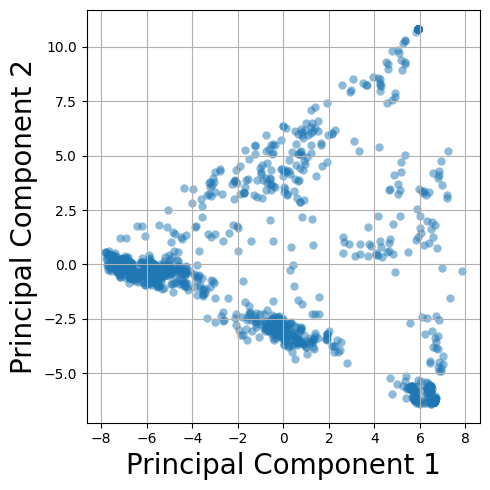

In [496]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="Principal Component 1", y="Principal Component 2", linewidth=0, alpha=0.5)
plt.grid()
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.tight_layout()
plt.show()

In [497]:
components = pca.fit_transform(rpca.L)
df = pd.DataFrame({
    "Principal Component 1": components[:, 0],
    "Principal Component 2": components[:, 1]
})

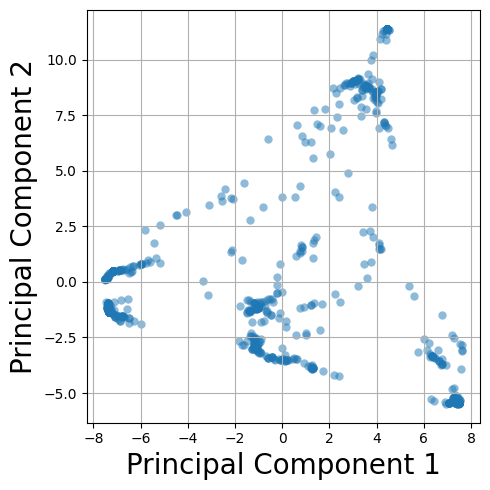

In [498]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="Principal Component 1", y="Principal Component 2", linewidth=0, alpha=0.5)
plt.grid()
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.tight_layout()
plt.show()

In [499]:
print(np.sum(X.T == (rpca.L)) / (X.shape[0] * X.shape[1]))
print(np.sum(X == (corrupted_matrix)) / (X.shape[0] * X.shape[1]))

0.7158893304074492
0.49161022477907595


In [500]:
pca = PCA(n_components=2)
reconstructed_pca = pca.inverse_transform(pca.fit_transform(corrupted_matrix.T))
resconstructed_rpca = pca.inverse_transform(pca.fit_transform(rpca.L))

# Compute reconstruction errors
error_rpca = np.linalg.norm(X.T - resconstructed_rpca, 'fro') / np.linalg.norm(X.T, 'fro')
error_pca = np.linalg.norm(X.T - reconstructed_pca, 'fro') / np.linalg.norm(X.T, 'fro')
print(error_rpca)
print(error_pca)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').